In [25]:
import numpy as np
import pandas as pd

## Reading the data

In [26]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [27]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [28]:
train.set_index('PassengerId', inplace = True)
test.set_index('PassengerId', inplace = True)

In [29]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [30]:
features_to_drop = ['Name', 'Ticket', 'Cabin']
train.drop(columns = features_to_drop, inplace = True)
test.drop(columns = features_to_drop, inplace = True)

In [31]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [32]:
train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [33]:
test.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

## Taking a look at the features

TODO

<Axes: ylabel='Frequency'>

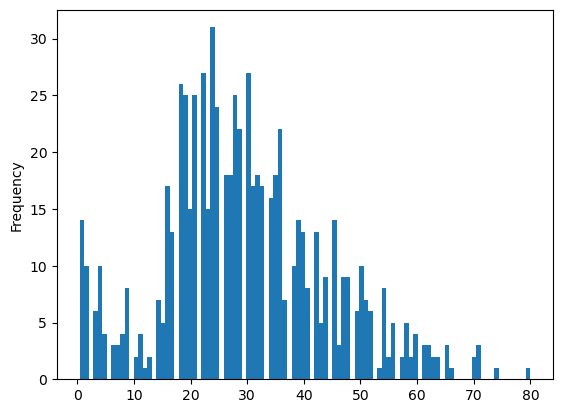

In [51]:
import matplotlib.pyplot as plt

train.Age.plot.hist(bins = 100)

<Axes: ylabel='Frequency'>

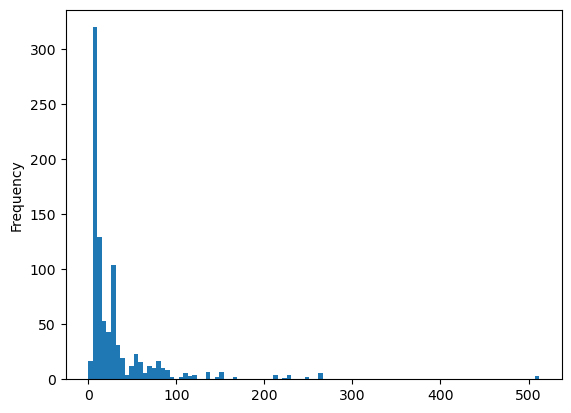

In [54]:
train.Fare.plot.hist(bins = 100)

Since values from Age feature are fairly close to normal distribution, we'll leave it alone, however normalizing Fare feature could benefit our scores

## Creating a function to estimate different models. 
Because the score in the competition is calculated on the percentage of passengers that were correctly predicted, we need to use accuracy_score metric

In [34]:
def model_estimation(y_true, y_pred):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_true, y_pred)

## Creating a pipeline

In [73]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

train.dropna(subset = ['Embarked'], inplace = True)

age_feature = ['Age']
age_pipe = Pipeline(steps = [
    ('imputer', SimpleImputer())
])

fare_feature = ['Fare']
fare_pipe = Pipeline(steps = [
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

cat_features = ['Sex', 'Embarked']
cat_pipe = Pipeline(steps = [
    ('cat_encoder', OneHotEncoder())
])

column_transformer = ColumnTransformer(
    transformers = [
        ('num_transform', age_pipe, age_feature), 
        ('cat_transform', cat_pipe, cat_features), 
        ('fare_normalize', fare_pipe, fare_feature)
    ]
)

model = Pipeline(
    steps = [
        ('preprocessor', column_transformer), 
        ('model', RandomForestClassifier())
    ]
)


## Testing different models on the pipeline

In [74]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = train.drop('Survived', axis = 1)
y = train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

models = {
    'linearSVC': LinearSVC(dual = 'auto', random_state = 0),
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(random_state = 0),
    'GradientBoosting': GradientBoostingClassifier(random_state = 1), 
    'RandomForest': RandomForestClassifier(random_state = 1)
}


models_metrics = {}

for model in models:
    clf = Pipeline(
        steps = [
            ('preprocessor', column_transformer), 
            ('model', models[model])
        ])

    models_metrics[model] = round(np.mean(cross_val_score(clf, X, y, scoring = 'accuracy', cv = 4)), 4)

            
models_metrics

{'linearSVC': 0.7806,
 'KNeighbors': 0.7503,
 'SVC': 0.6446,
 'GradientBoosting': 0.7998,
 'RandomForest': 0.7739}

### Scores on different models
1. linearSVC: 0.7806,
2. KNeighbors: 0.7503,
3. SVC: 0.6604,
4. GradientBoosting: `0.7998`
5. RandomForest: `0.7739`

As we can see, ensemble classifiers (GradientBoosting and RandomForest) appear to have bigger accuracy score. These are the models that we'll be trying to further improve. 

### Improving models

In [75]:
def create_pipeline_model(clf):
    model = Pipeline(
        steps = [
            ('preprocessor', column_transformer), 
            ('model', clf)
        ])
    return model

Improving RandomForest

In [85]:
from sklearn.model_selection import GridSearchCV

model = create_pipeline_model(RandomForestClassifier(random_state = 1))

pipe_grid = {
    'preprocessor__num_transform__imputer__strategy': ['mean', 'median'],
    'model__n_estimators': [100, 250, 300, 400, 1000],
    'model__max_depth': [None, 5],
    'model__max_features': [None], 
    'model__min_samples_split': [2, 4]
}

gs_model = GridSearchCV(model, pipe_grid, cv = 4, verbose = 2)
rf_y_preds = gs_model.fit(X_train, y_train).predict(X_test)

gs_RandomForest_metrics = model_estimation(y_test, rf_y_preds)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
[CV] END model__max_depth=None, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.3s
[CV] END model__max_depth=None, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.2s
[CV] END model__max_depth=None, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.2s
[CV] END model__max_depth=None, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.3s
[CV] END model__max_depth=None, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=median; total time=   0.2s
[CV] END model__max_d

In [86]:
# gs_model.score(X_test, y_test)
gs_RandomForest_metrics

0.797752808988764

In [79]:
gs_model.best_params_

{'model__max_depth': 5,
 'model__max_features': None,
 'model__min_samples_split': 2,
 'model__n_estimators': 1000,
 'preprocessor__num_transform__imputer__strategy': 'median'}

Improving GradientBoosting model

In [88]:
model = create_pipeline_model(GradientBoostingClassifier(random_state = 1))

gb_grid_search_pipe = {
    'preprocessor__num_transform__imputer__strategy': ['mean', 'median'],
    'model__n_estimators': [100, 200, 300, 400, 500], 
    'model__loss': ['log_loss', 'exponential'],
    'model__max_features': [None, 'sqrt', 'log2'],
    "model__learning_rate": [0.01, .2, 0.075, 0.1],
    'model__min_samples_split': [2, 4, 6]
}

gb_model = GridSearchCV(model, gb_grid_search_pipe, verbose = 2, cv = 4)
gb_y_preds = gb_model.fit(X_train, y_train).predict(X_test)

gs_GradientBoosting_metrics = model_estimation(y_test, gb_y_preds)

Fitting 4 folds for each of 720 candidates, totalling 2880 fits
[CV] END model__learning_rate=0.01, model__loss=log_loss, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.1s
[CV] END model__learning_rate=0.01, model__loss=log_loss, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.1s
[CV] END model__learning_rate=0.01, model__loss=log_loss, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.1s
[CV] END model__learning_rate=0.01, model__loss=log_loss, model__max_features=None, model__min_samples_split=2, model__n_estimators=100, preprocessor__num_transform__imputer__strategy=mean; total time=   0.1s
[CV] END model__learning_rate=0.01, model__loss=log_loss, model__max_features=None, model__min_sampl

In [90]:
gs_GradientBoosting_metrics

0.8258426966292135

In [91]:
gb_model.best_params_

{'model__learning_rate': 0.2,
 'model__loss': 'exponential',
 'model__max_features': None,
 'model__min_samples_split': 6,
 'model__n_estimators': 200,
 'preprocessor__num_transform__imputer__strategy': 'median'}

In [98]:
gradient_boosting_preds = gb_model.predict(test)
gradient_boosting_preds

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

In [109]:
random_forest_preds = gs_model.predict(test)
random_forest_preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [111]:
# solution = pd.DataFrame(test.index, y_preds)

In [110]:
# solution = pd.DataFrame({'PassengerID': test.index, 'Survived': gradient_boosting_preds})
# solution

,PassengerID,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [111]:
# solution.to_csv('titanic_solution.csv', header=True, index=None)